In [2]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy import special
import matplotlib.colors as colors
import numdifftools as nd

plt.rcParams.update({
    "text.usetex": True,
    "font.size": 9,
})

cmap = 'inferno' #'viridis' #'gray'

# Hartree Bose function - problem in initial condition x0

In [3]:
# Function to minimize
def fun(x, l, c):
    tr = x
    return (-1 + tr**2 * (-2 * l + tr * (tr - 4*c - 2 * tr *c**2)))/(1 + tr**2)**2

# Minimization
def HB_constants(l: float, c: float):
    """
    Returns the Hartree-Bose constants $B^+ = 1/sqrt(1+abs(t^2)) (t t^+ + s^+$ for a given lambda and chi for the Lipkin model.
    """
    x0 = 0.7
    bounds = [(-100, 100)]
    res = minimize(fun, x0, args=(l, c), method='SLSQP', bounds=bounds)
    return res.x

HB_constants(2, 0.5)

array([0.89043185])

In [47]:
x_range = np.linspace(-2, 2, 85)
y_range = np.linspace(-1.5, 1.5, 20)

# Initialize an empty array to store the values
val1 = np.zeros((len(x_range), len(y_range)))

for i, x in enumerate(x_range):
    for j, y in enumerate(y_range):
        constants = HB_constants(x, y)
        val1[i, j] = constants[0]

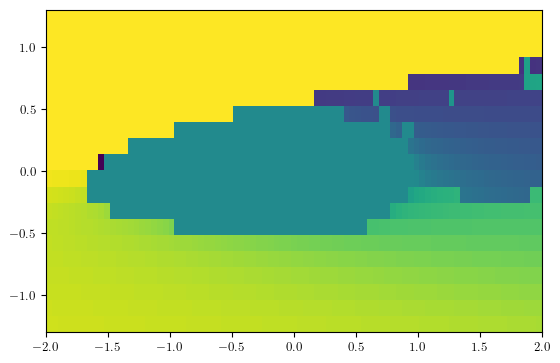

In [48]:
plt.imshow(np.arctan(val1.T), extent=[-2, 2, -1.3, 1.3])
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_ylabel'

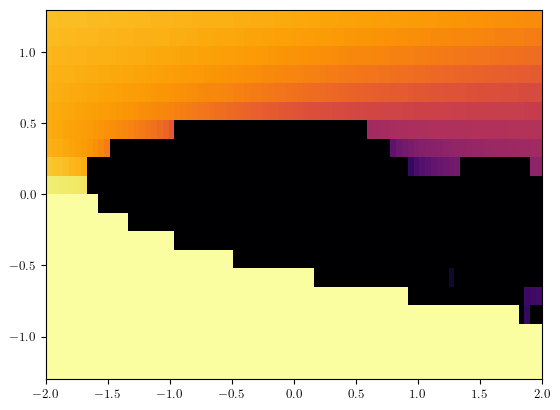

In [49]:
norm = plt.Normalize(0, np.pi/2) # Colorbar range

plt.imshow(np.arctan(val1.T), origin='lower', extent=[-2, 2, -1.3, 1.3], aspect='auto', norm=norm, cmap=cmap)
plt.set_ylabel(r'$\chi$')

plt.savefig('HB_constants_combined.pdf', bbox_inches='tight', pad_inches=0,backend='pgf', dpi=1200)
plt.show()

# Metric tensor

In [31]:
def Q(n, l, c):
    """
    Metric tensor of the ground state manifold in the Hartree-Bose limit of the Lipkin model.
    # Arguments
        n: int, the number of particles
        l: float, lambda
        c: float, chi
        dl: float, the step size for the finite difference method
    # Returns
        Q: array, the metric tensor [[Q11, Q12], [Q12, Q22]]
    """

    tr, ti = HB_constants(l, c)
    norm = np.sqrt(1 + np.abs(tr)**2 + np.abs(ti)**2)
    t, s = complex(tr, ti)/norm, complex(1, 0)/norm

    # Define a helper function to compute HB_constants for the step sizes
    def helper(l_arg, c_arg):
        tr_val, ti_val = HB_constants(l_arg, c_arg)
        return np.array([complex(tr_val, ti_val)/norm, complex(1, 0)/norm])
    
    # Compute gradients using numdifftools
    grad_l = nd.Gradient(lambda l_val: helper(l_val, c))
    grad_c = nd.Gradient(lambda c_val: helper(l, c_val))
    dt1, ds1 = grad_l(l)
    dt2, ds2 = grad_c(c)

    Q11 = n * (abs(ds1)**2 + abs(dt1)**2 - (s * ds1.conjugate() + t * dt1.conjugate()) * (ds1 * s.conjugate() + dt1 * t.conjugate()))
    Q12 = -n * (dt1.conjugate() * (dt2 * (-1 + abs(t)**2) + ds2 * t * s.conjugate()) + ds1.conjugate() * (-ds2 + ds2 * abs(s)**2 + dt2 * s * t.conjugate()))
    Q22 = n * (abs(ds2)**2 + abs(dt2)**2 - (s * ds2.conjugate() + t * dt2.conjugate()) * (ds2 * s.conjugate() + dt2 * t.conjugate()))


    return np.real([[Q11, Q12], [Q12, Q22]])
print(Q(10, 2, 2))
print(Q(10, 5, 5))
print(Q(10, 1, 1))
print(Q(10, -2, 0.3))

[[ 0.00787864 -0.04709665]
 [-0.04709665  0.28153248]]
[[ 5.12421585e-05 -5.75128684e-04]
 [-5.75128684e-04  6.45562930e-03]]
[[ 0.06844409 -0.41389089]
 [-0.41389089  2.50285653]]
[[5.28552538e-06 8.83305291e-06]
 [8.83305291e-06 1.47800949e-05]]


In [43]:
x_range = np.linspace(-2, 2, 50)
y_range = np.linspace(0, 1.3, 100)

In [44]:
def plotMetric(vals1:list, vals2:list, vals3:list):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(3.2, 6))
    norm = plt.Normalize(-np.pi/2, np.pi/2) # Colorbar range

    im1 = ax1.imshow(vals1, origin='lower', extent=[-2, 2, 0.01, 1.3], norm=norm, aspect='auto', cmap=cmap)
    ax1.set_ylabel(r'$\chi$')

    im2 = ax2.imshow(vals2, origin='lower', extent=[-2, 2, 0.01, 1.3], norm=norm, aspect='auto', cmap=cmap)
    ax2.set_ylabel(r'$\chi$')

    im3 = ax3.imshow(vals3, origin='lower', extent=[-2, 2, 0, 1.3], norm=norm, aspect='auto', cmap=cmap)
    ax3.set_xlabel(r'$\lambda$')
    ax3.set_ylabel(r'$\chi$')

    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(im1, cax=cbar_ax)
    fig.subplots_adjust(right=0.85, hspace=0)

    plt.savefig('metric_HB.pdf', bbox_inches='tight', pad_inches=0,backend='pgf', dpi=1200)
    plt.show()

In [45]:
g = np.array([[Q(10, x, y) for x in x_range] for y in y_range])
g11 = np.arctan(g[:,:,0,0])
g12 = np.arctan(g[:,:,0,1])
g22 = np.arctan(g[:,:,0,0])

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: 

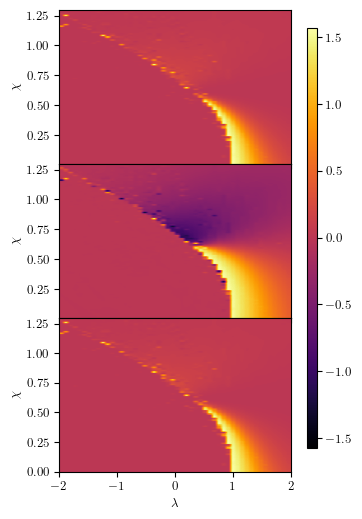

In [46]:
plotMetric(g11,g12,g22)

In [47]:
g = np.array([[Q(1000, x, y) for x in x_range] for y in y_range])
ggg11 = np.arctan(g[:,:,0,0])
ggg12 = np.arctan(g[:,:,0,1])
ggg22 = np.arctan(g[:,:,1,1])

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: 

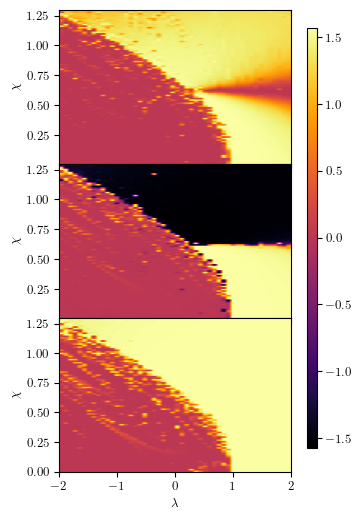

In [48]:
plotMetric(ggg11,ggg12,ggg22)

# Ricci scalar

In [66]:
def g(x:float, y:float):
    """Returns the metric tensor at the given coordinate `coord` for specific n."""
    return Q(10, x, y)
def det2(g):
    return g[0,0]*g[1,1] - g[0,1]*g[1,0]


def Abracket(x:float, y:float):
    """Helping function needed for the calculation of the simplified Ricci scalar `R(coord, H)`."""
    h = 1e-1  # small step size for numerical differentiation
    # Compute metric tensor at points needed for derivatives
    g_xph  = g(x + h, y)
    g_xmh  = g(x - h, y)
    g_yph  = g(x, y + h)
    g_ypmh = g(x, y - h)
    gg = g(x,y)
    det_g = det2(gg)
    sq = np.sqrt(np.abs(det_g))
    # Compute derivatives using precomputed metric tensors
    d1g22 = (g_xph[1,1] - g_xmh[1,1]) / (2 * h)
    d2g11 = (g_yph[0,0] - g_ypmh[0,0]) / (2 * h)
    
    return gg[0,1]/(gg[0,0]*sq) * d2g11 - d1g22/sq


def Bbracket(x:float, y:float):
    """Helping function needed for the calculation of the simplified Ricci scalar `R(coord, H)`."""
    h = 1e-1  # small step size for numerical differentiation
    # Compute metric tensor at points needed for derivatives
    g_xph  = g(x + h, y)
    g_xmh  = g(x - h, y)
    g_yph  = g(x, y + h)
    g_ypmh = g(x, y - h)
    gg = g(x, y)
    det_g = det2(gg)
    sq = np.sqrt(np.abs(det_g))
    # Compute derivatives using precomputed metric tensors
    d1g11 = (g_xph[0,0] - g_xmh[0,0]) / (2 * h)
    d1g12 = (g_xph[0,1] - g_xmh[0,1]) / (2 * h)
    d2g11 = (g_yph[0,0] - g_ypmh[0,0]) / (2 * h)

    return 2*d1g12/sq - d2g11/sq - gg[0,1]/(gg[0,0]*sq) * d1g11

def R(x:float, y:float):
    """
    Ricci scalar calculated using simplified formula for Riemannian 2D manifold.
    """
    h = 1e-1  # small step size for numerical differentiation
    d1A = (Abracket(x + h, y) - Abracket(x - h, y)) / (2 * h)
    d2B = (Bbracket(x, y + h) - Bbracket(x, y - h)) / (2 * h)
    
    return (d1A+d2B)/np.sqrt(np.abs(det2(g(x,y))))

In [67]:
print(R(-1,0.5))
print(R(1,0.5))
print(R(1,1))
print(R(-1,-0.5))
print(R(-1,-1.5))

/var/folders/jy/cmz4x5wj40z2z8682sjl9ydc0000gn/T/ipykernel_26008/1116204308.py:23: RuntimeWarning: invalid value encountered in scalar divide
  return gg[0,1]/(gg[0,0]*sq) * d2g11 - d1g22/sq
/var/folders/jy/cmz4x5wj40z2z8682sjl9ydc0000gn/T/ipykernel_26008/1116204308.py:42: RuntimeWarning: invalid value encountered in scalar divide
  return 2*d1g12/sq - d2g11/sq - gg[0,1]/(gg[0,0]*sq) * d1g11


nan


/var/folders/jy/cmz4x5wj40z2z8682sjl9ydc0000gn/T/ipykernel_26008/1116204308.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  return gg[0,1]/(gg[0,0]*sq) * d2g11 - d1g22/sq
/var/folders/jy/cmz4x5wj40z2z8682sjl9ydc0000gn/T/ipykernel_26008/1116204308.py:23: RuntimeWarning: invalid value encountered in scalar subtract
  return gg[0,1]/(gg[0,0]*sq) * d2g11 - d1g22/sq


nan
1.456819835461127e+17
nan


/var/folders/jy/cmz4x5wj40z2z8682sjl9ydc0000gn/T/ipykernel_26008/1116204308.py:23: RuntimeWarning: invalid value encountered in scalar divide
  return gg[0,1]/(gg[0,0]*sq) * d2g11 - d1g22/sq
/var/folders/jy/cmz4x5wj40z2z8682sjl9ydc0000gn/T/ipykernel_26008/1116204308.py:42: RuntimeWarning: invalid value encountered in scalar divide
  return 2*d1g12/sq - d2g11/sq - gg[0,1]/(gg[0,0]*sq) * d1g11


-7.937177324550492e+20


In [61]:
def g(x: float, y: float):
    """Returns the metric tensor at the given coordinate `coord` for specific n."""
    return Q(10, x, y)


def det2(g):
    return g[0, 0] * g[1, 1] - g[0, 1] * g[1, 0]


def compute_derivatives(f, x, y):
    # Create a vector function for numerical differentiation
    vec_f = lambda coord: f(coord[0], coord[1])
    
    # Calculate grad_f as a vector and the Jacobian as a matrix
    grad_f = nd.Gradient(vec_f)(np.array([x, y]))
    jacobian_f = nd.Jacobian(vec_f)(np.array([x, y]))

    return grad_f, jacobian_f


def Abracket(x: float, y: float):
    gg = g(x, y)
    det_g = det2(gg)
    sq = np.sqrt(np.abs(det_g))
    
    _, jacobian_g = compute_derivatives(g, x, y)
    
    d1g22 = jacobian_g[1, 1, 0]
    d2g11 = jacobian_g[0, 0, 1]
    
    return gg[0, 1] / (gg[0, 0] * sq) * d2g11 - d1g22 / sq


def Bbracket(x: float, y: float):
    gg = g(x, y)
    det_g = det2(gg)
    sq = np.sqrt(np.abs(det_g))
    
    _, jacobian_g = compute_derivatives(g, x, y)

    d1g11 = jacobian_g[0, 0, 0]
    d1g12 = jacobian_g[0, 1, 0]
    d2g11 = jacobian_g[0, 0, 1]

    return 2 * d1g12 / sq - d2g11 / sq - gg[0, 1] / (gg[0, 0] * sq) * d1g11


def R(x: float,y: float):
    gg = g(x, y)
    det_g = det2(gg)

    grad_A, _ = compute_derivatives(Abracket, x, y)
    grad_B, _ = compute_derivatives(Bbracket, x, y)

    d1A = grad_A[0]
    d2B = grad_B[1]

    return (d1A + d2B) / np.sqrt(np.abs(det_g))

In [63]:
R(-1,0.5)

/opt/homebrew/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/opt/homebrew/lib/python3.11/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/opt/homebrew/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/opt/homebrew/lib/python3.11/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/opt/homebrew/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/opt/homebrew/lib/python3.11/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))
/opt/homebrew/lib/python3.11/site-packages/numpy/lib/nanfunct

nan